# Multi-Class Image Classification using PyTorch for Beginners

I have fine tuned pre-trained VGG16 model, you can create your own model or use any pre-built pytorch model. More details [here](https://pytorch.org/docs/stable/torchvision/models.html).

In [3]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt

DIR_TRAIN = "../train/"
DIR_VALID = "../valid/"
DIR_TEST = "../test/"

In [4]:
### Exploring Dataset

classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(DIR_TRAIN + _class))
    valid_count += len(os.listdir(DIR_VALID + _class))
    test_count += len(os.listdir(DIR_TEST + _class))

print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)
    

Total Classes:  525
Total train images:  84635
Total valid images:  2625
Total test images:  2625


In [5]:
### Creating a list of all images : DIR_TRAIN/class_folder/img.jpg - FOR METHOD 2 of data loading
#   A dict for mapping class labels to index

train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)
        
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}
    

There are multiple ways to load images from the dataset, I have used 2 such methods:
1. Using ImageFolder Class
2. Using Dataset Class

In [6]:
### Loading Classification Dataset - FOR METHOD 2: For multi-class data, by inheriting Dataset class

def get_transform():
    return T.Compose([T.ToTensor()])

class BirdDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        return image, label
        
        
        
    def __len__(self):
        return len(self.imgs_list)


In [7]:
### Loading Classification Dataset

"""
# Method 1: For multi-class data directly from folders using ImageFolder
train_dataset = ImageFolder(root = DIR_TRAIN, transform = T.ToTensor())
valid_dataset = ImageFolder(root = DIR_VALID, transform = T.ToTensor())
test_dataset = ImageFolder(root = DIR_TEST, transform = T.ToTensor())
"""

# Method 2: Using Dataset Class
train_dataset = BirdDataset(train_imgs, class_to_int, get_transform())
valid_dataset = BirdDataset(valid_imgs, class_to_int, get_transform())
test_dataset = BirdDataset(test_imgs, class_to_int, get_transform())

#Data Loader  -  using Sampler (YT Video)
train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

#Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler = train_random_sampler,
    num_workers = 4,
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    sampler = valid_random_sampler,
    num_workers = 4,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    sampler = test_random_sampler,
    num_workers = 4,
)

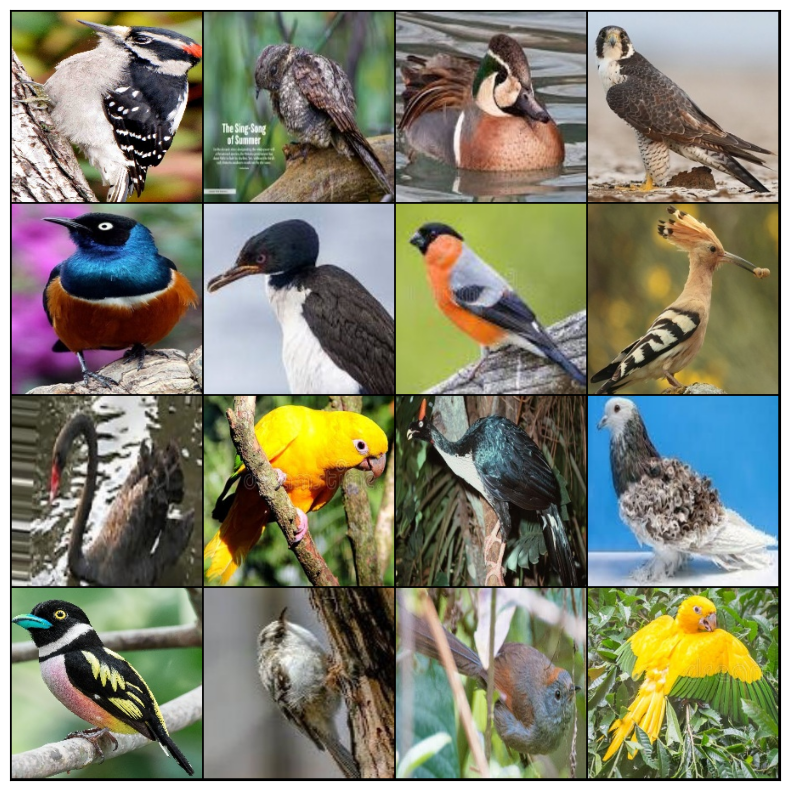

In [8]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [9]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


/root/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:32<00:00, 17.0MB/s] 


In [10]:
### Get device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 20


In [11]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

I did not execute training code given below as it takes time, you can fork this notebook and try yourself.

In [12]:
### Training Code

for epoch in range(epochs):
    
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
    #Validation
    for images, labels in valid_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
    

RuntimeError: index 309 is out of bounds for dimension 1 with size 200